In [2]:
import pandas as pd
import glob
import json
import re
import os

In [3]:
files = glob.glob("/log/worker2/shieldx-client*")

In [4]:
def load_multiline_json(path, run_id):
    records = []
    buffer = ""
    with open(path, "r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            buffer += line
            if line.endswith("}"):   # fin de objeto JSON
                try:
                    rec = json.loads(buffer)
                    rec["source_file"] = path
                    rec["run_id"] = run_id
                    records.append(rec)
                except Exception as e:
                    print("❌ Error parseando:", buffer[:100], e)
                buffer = ""  # reset
    return records

In [5]:
all_records = []

for f in files:
    if f.endswith(".error"):
        continue
    run_id = os.path.basename(f)  # usar el nombre del archivo como id de corrida
    all_records.extend(load_multiline_json(f, run_id))

df = pd.DataFrame(all_records)
print("Columnas:", df.columns)
print("Total registros:", len(df))
print("Corridas distintas:", df['run_id'].nunique())

Columnas: Index(['timestamp', 'level', 'logger_name', 'thread_name', 'event', 'path',
       'status', 'time', 'source_file', 'run_id'],
      dtype='object')
Total registros: 155008
Corridas distintas: 16


In [6]:
df["operation"] = df["event"].str.extract(r"CLIENT\.([A-Z_]+)")
def extract_entity(path: str) -> str:
    if path is None:
        return "unknown"
    if re.search(r"/event-types/.*/triggers", path):
        return "event_type_trigger"
    if re.search(r"/triggers/.*/rules", path):
        return "rule_trigger"
    if re.search(r"/triggers/.*/children", path):
        return "trigger_trigger"
    return path.strip("/").split("/")[0]

df["entity"] = df["path"].apply(extract_entity)

In [7]:
def map_to_crud(op: str) -> str:
    if op is None:
        return "OTHER"
    op = op.upper()
    # Primero DELETE/UNLINK/REMOVE
    if any(word in op for word in ["DELETE", "UNLINK", "REMOVE"]):
        return "DELETE"
    # Luego CREATE/LINK
    if any(word in op for word in ["CREATE", "LINK"]):
        return "CREATE"
    # Después READ
    if any(word in op for word in ["GET", "LIST", "READ"]):
        return "READ"
    # Después UPDATE
    if "UPDATE" in op or "REPLACE" in op:
        return "UPDATE"
    return "OTHER"

df["crud"] = df["operation"].apply(map_to_crud)


In [8]:
df

,timestamp,level,logger_name,thread_name,event,path,status,time,source_file,run_id,operation,entity,crud
0,"2025-08-27 01:37:29,027",INFO,shieldx-client,MainThread,CLIENT.DELETE_EVENT_TYPE.RESPONSE,/event-types/68aeb5b81e35766f11e9cefc,204,0.092604,/log/worker2/shieldx-client.2025-08-27_01-44,shieldx-client.2025-08-27_01-44,DELETE_EVENT_TYPE,event-types,DELETE
1,"2025-08-27 01:37:29,132",INFO,shieldx-client,MainThread,CLIENT.CREATE_EVENT_TYPE.RESPONSE,/event-types,201,0.104789,/log/worker2/shieldx-client.2025-08-27_01-44,shieldx-client.2025-08-27_01-44,CREATE_EVENT_TYPE,event-types,CREATE
2,"2025-08-27 01:37:29,218",INFO,shieldx-client,MainThread,CLIENT.GET_EVENT_TYPE_BY_ID.RESPONSE,/event-types/68aeb5b91e35766f11e9cefd,200,0.084764,/log/worker2/shieldx-client.2025-08-27_01-44,shieldx-client.2025-08-27_01-44,GET_EVENT_TYPE_BY_ID,event-types,READ
3,"2025-08-27 01:37:29,276",INFO,shieldx-client,MainThread,CLIENT.DELETE_EVENT_TYPE.RESPONSE,/event-types/68aeb5b91e35766f11e9cefd,204,0.057602,/log/worker2/shieldx-client.2025-08-27_01-44,shieldx-client.2025-08-27_01-44,DELETE_EVENT_TYPE,event-types,DELETE
4,"2025-08-27 01:37:29,333",INFO,shieldx-client,MainThread,CLIENT.CREATE_EVENT_TYPE.RESPONSE,/event-types,201,0.056937,/log/worker2/shieldx-client.2025-08-27_01-44,shieldx-client.2025-08-27_01-44,CREATE_EVENT_TYPE,event-types,CREATE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155003,"2025-08-27 02:04:16,624",INFO,shieldx-client,MainThread,CLIENT.LIST_TRIGGERS_FOR_EVENT_TYPE.RESPONSE,/event-types/68aeb7531e35766f11e9d580/triggers,200,0.094373,/log/worker2/shieldx-client.2025-08-27_01-54,shieldx-client.2025-08-27_01-54,LIST_TRIGGERS_FOR_EVENT_TYPE,event_type_trigger,READ
155004,"2025-08-27 02:04:16,702",INFO,shieldx-client,MainThread,CLIENT.REPLACE_TRIGGERS_FOR_EVENT_TYPE.RESPONSE,/event-types/68aeb7531e35766f11e9d580/triggers,204,0.077923,/log/worker2/shieldx-client.2025-08-27_01-54,shieldx-client.2025-08-27_01-54,REPLACE_TRIGGERS_FOR_EVENT_TYPE,event_type_trigger,UPDATE
155005,"2025-08-27 02:04:16,810",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aeb7531e35766f11e9d580/triggers...,204,0.107811,/log/worker2/shieldx-client.2025-08-27_01-54,shieldx-client.2025-08-27_01-54,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE
155006,"2025-08-27 02:04:16,878",INFO,shieldx-client,MainThread,CLIENT.UNLINK_TRIGGER_FROM_EVENT_TYPE.RESPONSE,/event-types/68aeb7531e35766f11e9d580/triggers...,204,0.067107,/log/worker2/shieldx-client.2025-08-27_01-54,shieldx-client.2025-08-27_01-54,UNLINK_TRIGGER_FROM_EVENT_TYPE,event_type_trigger,DELETE


In [9]:
crud_metrics = df.groupby(["entity", "crud"])["time"].agg(
    avg="mean", min="min", max="max", std="std", count="count"
).reset_index()

In [10]:
print("\n📊 Métricas totales:")
print(crud_metrics.sort_values(["entity", "crud"]))


📊 Métricas totales:
                entity    crud       avg       min       max       std  count
0          event-types  CREATE  0.066422  0.051924  2.359259  0.037902   5002
1          event-types  DELETE  0.068417  0.053751  1.062011  0.024399   5000
2          event-types    READ  0.065671  0.050592  0.296237  0.017876   5000
3   event_type_trigger  CREATE  0.077076  0.054849  0.337509  0.028168   5000
4   event_type_trigger  DELETE  0.075483  0.052397  2.060200  0.033246  15000
5   event_type_trigger    READ  0.074933  0.052409  0.333185  0.027960   5000
6   event_type_trigger  UPDATE  0.077350  0.054714  0.462688  0.028785   5000
7               events  CREATE  0.077358  0.053308  0.842110  0.029988   5000
8               events  DELETE  0.074125  0.051821  0.675947  0.027910   5000
9               events    READ  0.074174 -0.398663  0.284280  0.026508   5000
10              events  UPDATE  0.076696  0.054187  0.734295  0.027630   5000
11        rule_trigger  CREATE  0.068004  0

In [11]:
crud_by_run = df.groupby(["run_id", "entity", "crud"])["time"].agg(
    avg="mean", min="min", max="max", std="std", count="count"
).reset_index()

print("\n📊 Métricas separadas por corrida:")
print(crud_by_run.head(20))


📊 Métricas separadas por corrida:
                             run_id              entity    crud       avg  \
0                    shieldx-client     trigger_trigger  CREATE  0.069026   
1                    shieldx-client     trigger_trigger  DELETE  0.064504   
2                    shieldx-client     trigger_trigger    READ  0.066539   
3                    shieldx-client            triggers    READ  0.064349   
4   shieldx-client.2025-08-27_01-27         event-types  CREATE  0.067803   
5   shieldx-client.2025-08-27_01-27         event-types  DELETE  0.069950   
6   shieldx-client.2025-08-27_01-27         event-types    READ  0.066500   
7   shieldx-client.2025-08-27_01-44         event-types  CREATE  0.064426   
8   shieldx-client.2025-08-27_01-44         event-types  DELETE  0.066270   
9   shieldx-client.2025-08-27_01-44         event-types    READ  0.064509   
10  shieldx-client.2025-08-27_01-44  event_type_trigger  CREATE  0.066913   
11  shieldx-client.2025-08-27_01-44  even

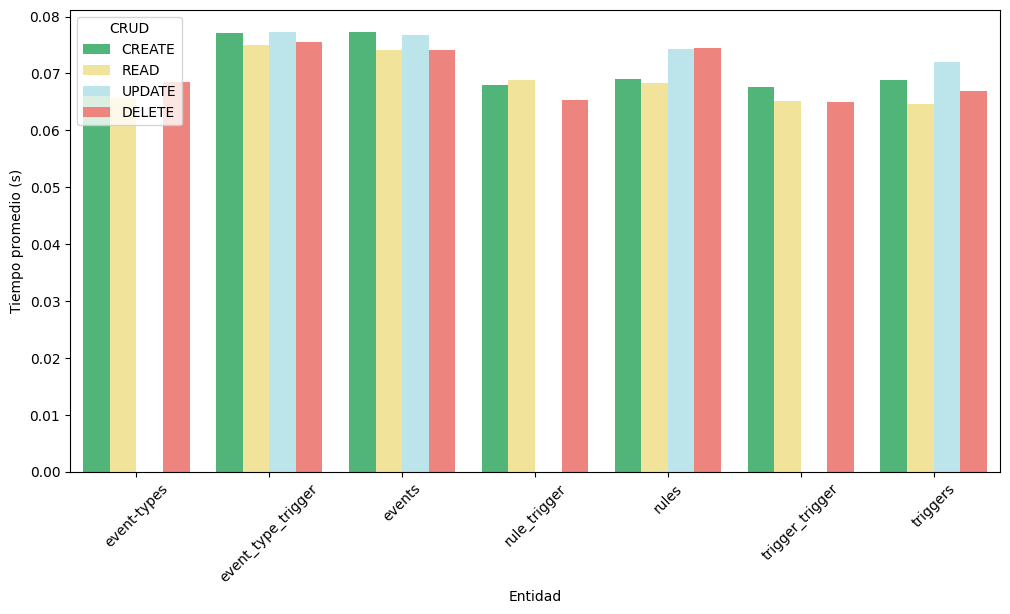

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reordenar niveles CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)

crud_avg = df.groupby(["entity", "crud"])["time"].mean().reset_index()
# Paleta de colores pastel
crud_palette = {
    "CREATE": "#40c576",   # verde pastel
    "READ":   "#ffee8c",   # amarillo pastel
    "UPDATE": "#b3ebf2",   # azul pastel
    "DELETE": "#ff746c"    # rojo pastel
}

# --- Barras promedio ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=crud_avg,
    x="entity",
    y="time",
    hue="crud",
    palette=crud_palette
)


plt.ylabel("Tiempo promedio (s)")
plt.xlabel("Entidad")
plt.xticks(rotation=45)
plt.legend(title="CRUD")
plt.show()



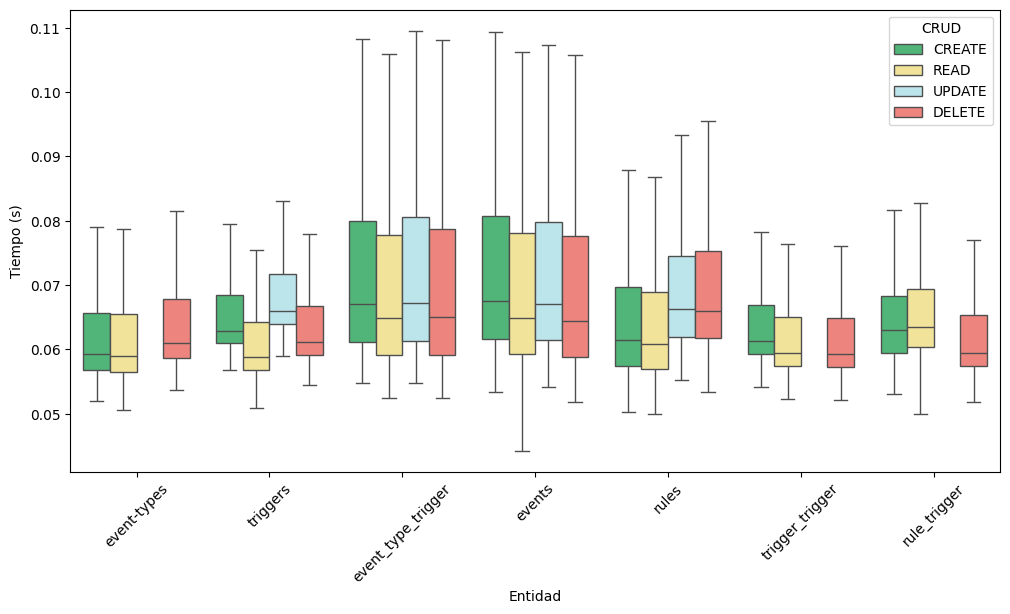

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mantener orden de CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)

# Paleta de colores pastel
crud_palette = {
    "CREATE": "#40c576",   # verde pastel
    "READ":   "#ffee8c",   # amarillo pastel
    "UPDATE": "#b3ebf2",   # azul pastel
    "DELETE": "#ff746c"    # rojo pastel
}

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df["crud"] != "OTHER"],  # usar df completo
    x="entity",
    y="time",
    hue="crud",
    palette=crud_palette,
    showfliers=False
)


plt.ylabel("Tiempo (s)")
plt.xlabel("Entidad")
plt.xticks(rotation=45)
plt.legend(title="CRUD")
plt.show()


/tmp/ipykernel_8442/2226019900.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


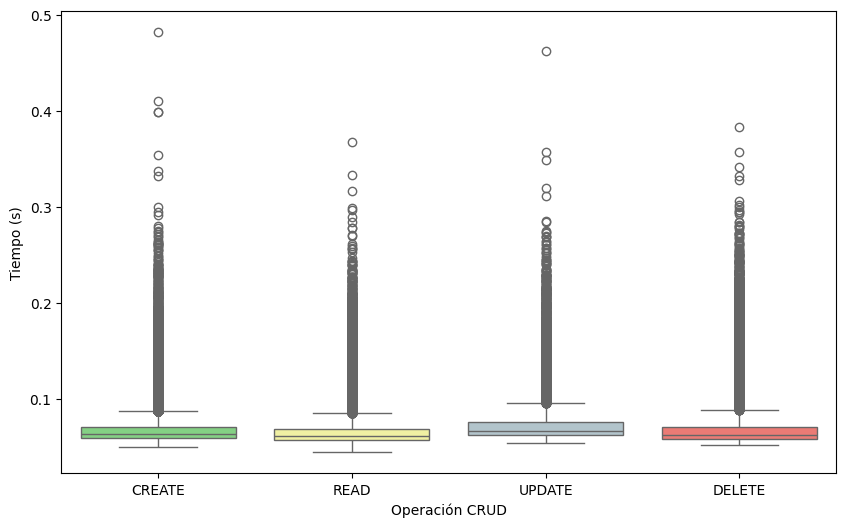

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo operaciones CRUD y tiempos menores a 2s
# Ordenar CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)


df_crud_only = df[
    (df["crud"].isin(["CREATE", "READ", "UPDATE", "DELETE"])) &
    (df["time"] > 0) &   # 👈 quitar negativos y ceros
    (df["time"] <= 0.5)
]



# Paleta de colores pastel
crud_palette = {
    "CREATE": "#77dd77",   # verde pastel
    "READ":   "#fdfd96",   # amarillo pastel
    "UPDATE": "#aec6cf",   # azul pastel
    "DELETE": "#ff6961"    # rojo pastel
}

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_crud_only,
    x="crud",
    y="time",
    palette=crud_palette,
    showfliers=True   # si quieres ocultar todos los outliers pon False
)


plt.ylabel("Tiempo (s)")
plt.xlabel("Operación CRUD")
plt.show()
